#### Define Imports

In [1]:
import torch

import matplotlib.pyplot as plt
%matplotlib inline

#### Define Constants

In [2]:
INPUT_DATA_FILEPATH = "../data/names.txt"

#### Pull Data

In [3]:
words = open(INPUT_DATA_FILEPATH, "r").read().splitlines()

In [4]:
words[:3]

['emma', 'olivia', 'ava']

#### Basic Exploratory Data Analysis

In [5]:
print(f"There are {len(words)} names in the dataset from filepath {INPUT_DATA_FILEPATH}")

There are 32033 names in the dataset from filepath ../data/names.txt


In [6]:
print(f"The shortest name in the dataset is {min(len(word) for word in words)} characters long")

The shortest name in the dataset is 2 characters long


In [7]:
print(f"The longest name in the dataset is {max(len(word) for word in words)} characters long")

The longest name in the dataset is 15 characters long


#### Build model

In [8]:
SPECIAL_TOKEN = "."

In [9]:
unique_chars = sorted(list(set("".join(words))))

unique_chars

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [10]:
char_2_int = {char: index + 1 for index, char in enumerate(unique_chars)}
char_2_int[SPECIAL_TOKEN] = 0
int_2_char = {index: char for char, index in char_2_int.items()}

int_2_char

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [15]:
N = torch.zeros((len(unique_chars) + 1,len(unique_chars) + 1)) # + 1 for special token

In [16]:
for word in words:
    chars = [SPECIAL_TOKEN] + list(word) + [SPECIAL_TOKEN]
    for char_1, char_2 in zip(chars, chars[1:]):
        x = char_2_int[char_1]
        y = char_2_int[char_2]
        N[x, y] += 1

(-0.5, 26.5, 26.5, -0.5)

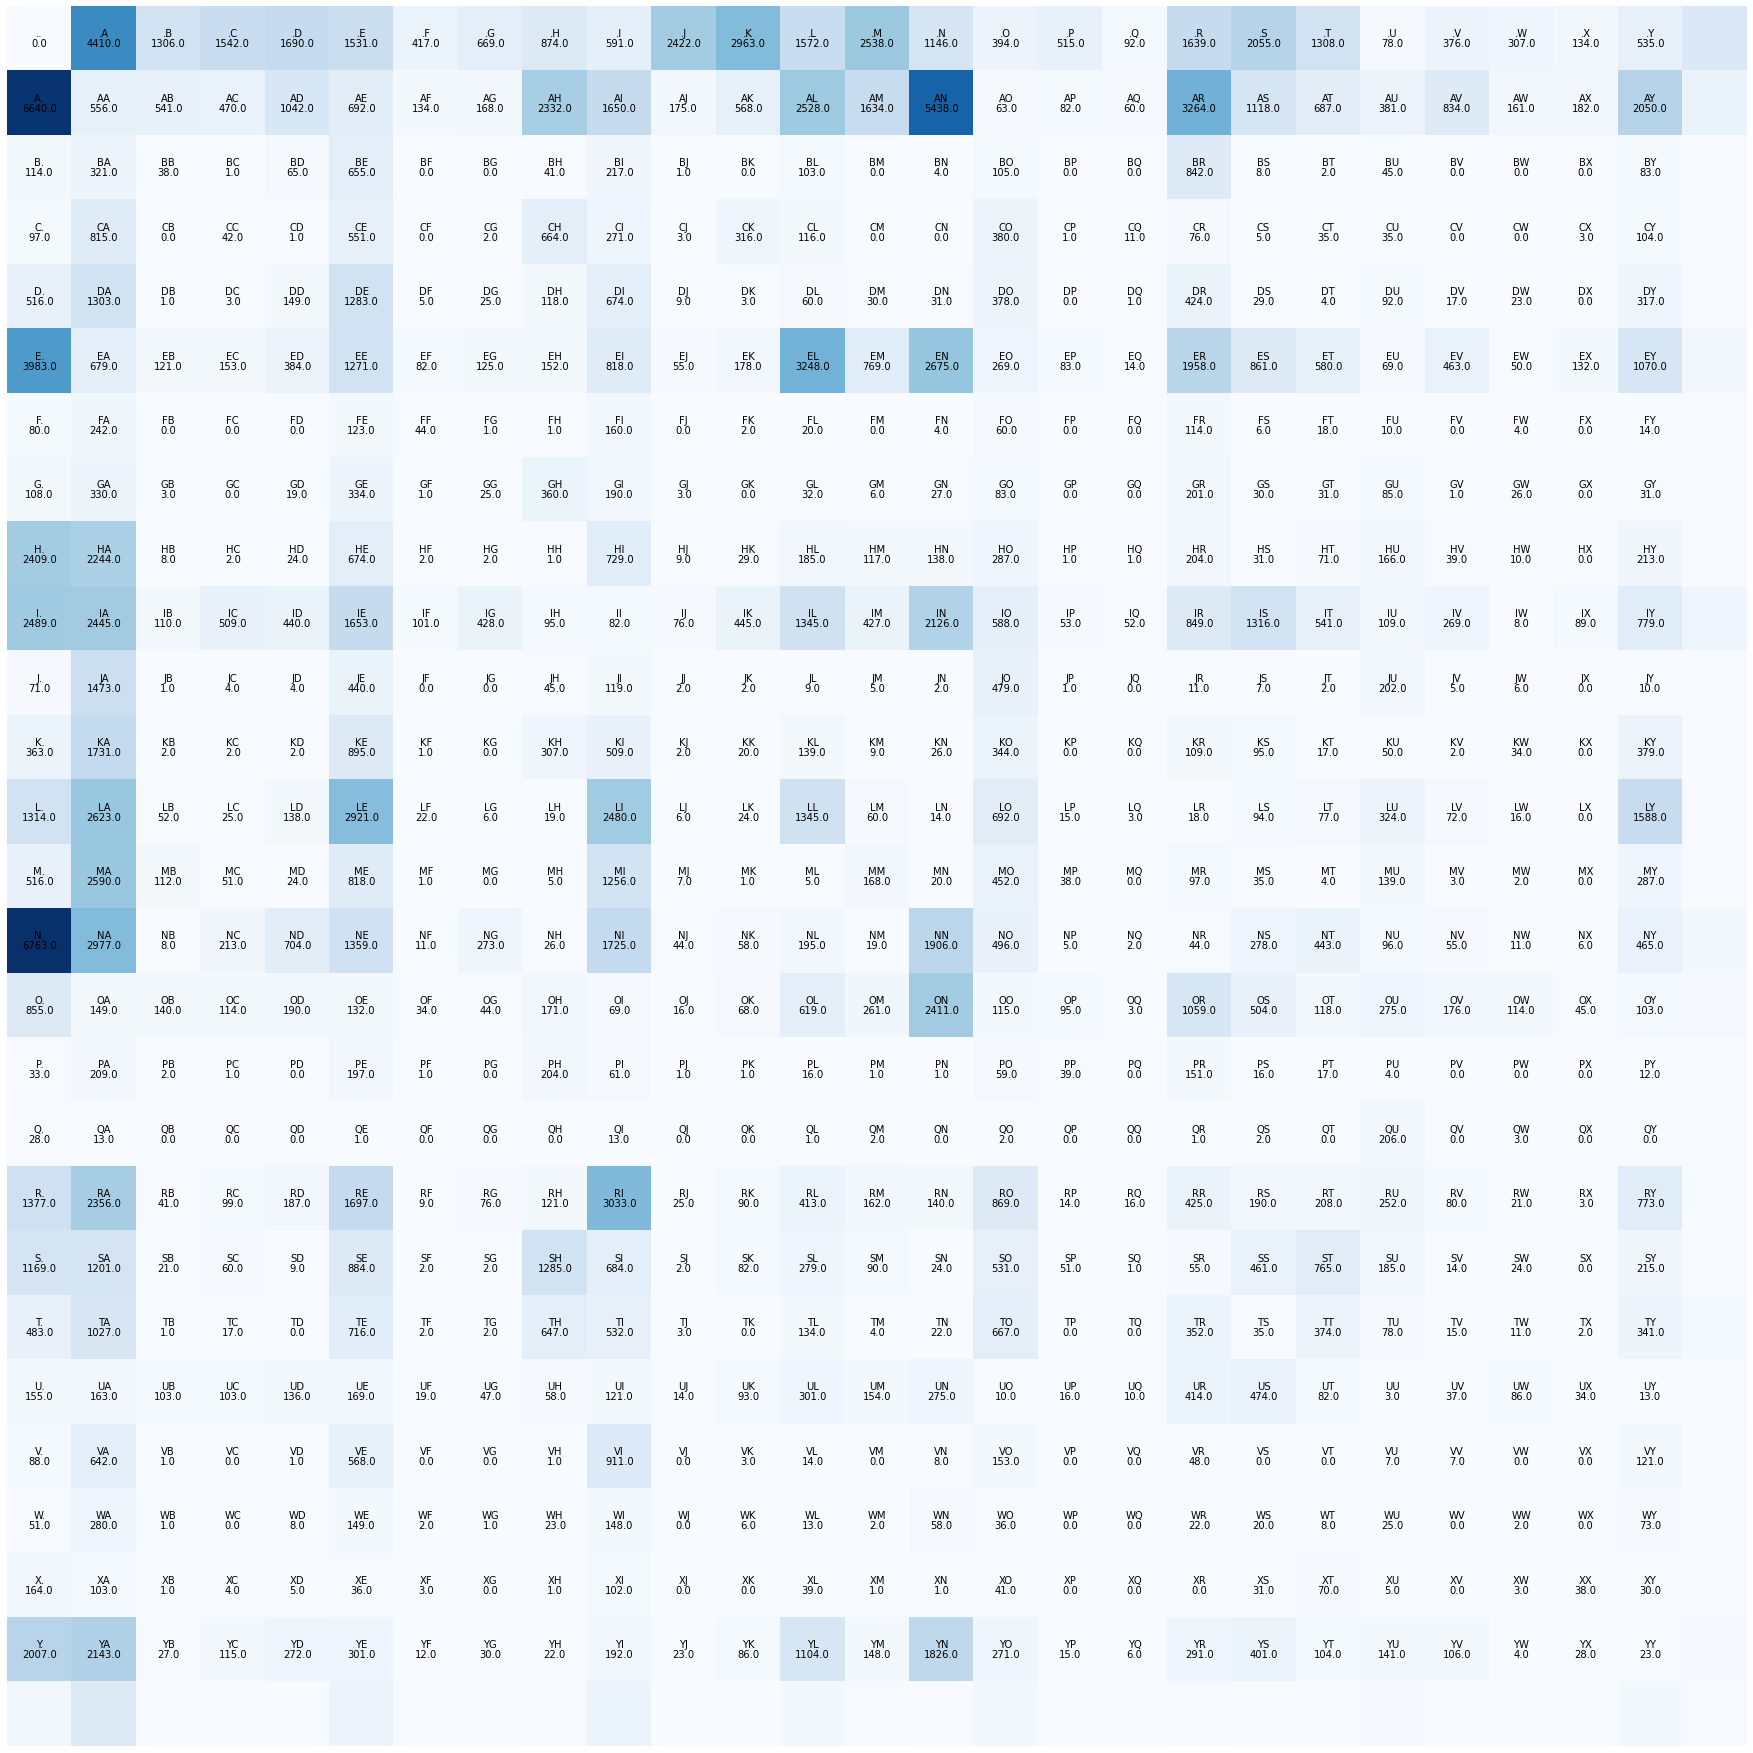

In [17]:
plt.figure(figsize=(32, 32))
plt.imshow(N, cmap="Blues")
for index_x in range(len(unique_chars)):
    for index_y in range(len(unique_chars)):
        curr_chars =  f"{int_2_char[index_x]}{int_2_char[index_y]}".upper()
        plt.text(index_y, index_x, curr_chars, ha="center", va="bottom", color="black")
        plt.text(index_y, index_x, N[index_x, index_y].item(), ha="center", va="top", color="black")
plt.axis("off")

In [18]:
N[0, :]

tensor([   0., 4410., 1306., 1542., 1690., 1531.,  417.,  669.,  874.,  591.,
        2422., 2963., 1572., 2538., 1146.,  394.,  515.,   92., 1639., 2055.,
        1308.,   78.,  376.,  307.,  134.,  535.,  929.])

In [33]:
prob = N[0].float()
prob /= prob.sum()
print(f"Sum = {prob.sum()}")
prob

Sum = 1.0


tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [29]:
generator = torch.Generator().manual_seed(2147483647)
prob = torch.rand(3, generator=generator)
prob = prob / prob.sum()
prob

tensor([0.6064, 0.3033, 0.0903])

In [30]:
torch.multinomial(prob, num_samples=20, replacement=True, generator=generator)

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [63]:
# optimize bigrad model
P = (N+1).float() # smoothing (N+1) - more you add more smoothing will be added (closer to uniform distribution)
P = P / P.sum(1, keepdim=True) # allowed thanks to broadcasting -> (27,1) is copy pasted to create (27,27) matrix
P.shape

torch.Size([27, 27])

In [64]:
assert P[0].sum().item() == 1 # have to be equal to 1

In [65]:
generator = torch.Generator().manual_seed(2147483647)

for i in range(20):
    index_x = 0
    name = ""
    while True:
        curr_prob = P[index_x]
        
        index_x = torch.multinomial(curr_prob, num_samples=1, replacement=True, generator=generator).item()
        name += int_2_char[index_x]
        if index_x == 0: # index of the last character '.'
            print(name)
            break

qur.
axx.
quriymoryles.
miemiaisah.
.
qunshizarie.
sabren.
jaddash.
jallligrien.
hayrer.
ia.
x.
cajayn.
jeimannariaenien.
ca.
h.
beonema.
.
xtttanakeroruceyaaxatona.
pamoynayrkiedengin.


In [66]:
for word in ["michalqq"]:
    chars = [SPECIAL_TOKEN] + list(word) + [SPECIAL_TOKEN]
    log_likelihood = 0
    n = 0
    for char_1, char_2 in zip(chars, chars[1:]):
        x = char_2_int[char_1]
        y = char_2_int[char_2]
        prob = P[x, y] # random prob is equal to 1/27 (unique char count)
        log_prob = torch.log(prob)
        log_likelihood += log_prob
        n += 1
        print(f"{char_1}{char_2}: {prob:.4f} {log_prob:.4f}")
    print(f"{log_likelihood=}")
    nll = -log_likelihood
    print(f"{nll=}")
    print(f"{nll/n=}")

.m: 0.0385 -3.2560
mi: 0.1885 -1.6687
ic: 0.0288 -3.5485
ch: 0.1869 -1.6774
ha: 0.2937 -1.2251
al: 0.0746 -2.5959
lq: 0.0003 -8.1594
qq: 0.0033 -5.7004
q.: 0.0970 -2.3331
log_likelihood=tensor(-30.1647)
nll=tensor(30.1647)
nll/n=tensor(3.3516)


### Neural Network

#### Create the training set of bigrams

In [68]:
X, y = [], []
for word in words[:1]:
    chars = [SPECIAL_TOKEN] + list(word) + [SPECIAL_TOKEN]
    for char_1, char_2 in zip(chars, chars[1:]):
        index_char_1 = char_2_int[char_1]
        index_char_2 = char_2_int[char_2]
        
        X.append(index_char_1)
        y.append(index_char_2)
        
X = torch.tensor(X)
y = torch.tensor(y)

In [69]:
X

tensor([ 0,  5, 13, 13,  1])

In [70]:
y

tensor([ 5, 13, 13,  1,  0])

In [79]:
import torch.nn.functional as f

x_encoded = f.one_hot(X, num_classes=27).float() 
# float because we will float the vectoris into net

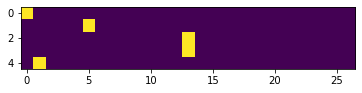

In [80]:
plt.imshow(x_encoded)

In [81]:
x_encoded.shape

torch.Size([5, 27])

In [82]:
x_encoded.dtype

torch.float32

In [92]:
generator = torch.Generator().manual_seed(2147483647)

W = torch.randn((27, 27), generator=generator) # init weights randomly
x_encoded @ W # (5, 27) @ (27, 27) -> (5,27)
# we look on firing rate for specified input 

tensor([[ 1.5674e+00, -2.3729e-01, -2.7385e-02, -1.1008e+00,  2.8588e-01,
         -2.9643e-02, -1.5471e+00,  6.0489e-01,  7.9136e-02,  9.0462e-01,
         -4.7125e-01,  7.8682e-01, -3.2843e-01, -4.3297e-01,  1.3729e+00,
          2.9334e+00,  1.5618e+00, -1.6261e+00,  6.7716e-01, -8.4039e-01,
          9.8488e-01, -1.4837e-01, -1.4795e+00,  4.4830e-01, -7.0730e-02,
          2.4968e+00,  2.4448e+00],
        [ 4.7236e-01,  1.4830e+00,  3.1748e-01,  1.0588e+00,  2.3982e+00,
          4.6827e-01, -6.5650e-01,  6.1662e-01, -6.2197e-01,  5.1007e-01,
          1.3563e+00,  2.3445e-01, -4.5585e-01, -1.3132e-03, -5.1161e-01,
          5.5570e-01,  4.7458e-01, -1.3867e+00,  1.6229e+00,  1.7197e-01,
          9.8846e-01,  5.0657e-01,  1.0198e+00, -1.9062e+00, -4.2753e-01,
         -2.1259e+00,  9.6041e-01],
        [ 1.9359e-01,  1.0532e+00,  6.3393e-01,  2.5786e-01,  9.6408e-01,
         -2.4855e-01,  2.4756e-02, -3.0404e-02,  1.5622e+00, -4.4852e-01,
         -1.2345e+00,  1.1220e+00, -6.73

In [94]:
logits = (x_encoded @ W) # log-counts

# softmax
counts = logits.exp() # equvalent N
probs = counts / counts.sum(1, keepdims=True)
# softmax

probs

tensor([[0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
         0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
         0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459],
        [0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
         0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
         0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0150, 0.0086,

In [90]:
probs[0].sum()

tensor(1.0000)

In [91]:
# we would like to optimize W